# Table of Contents
 <p><div class="lev1 toc-item"><a href="#OSMI-Health-Survey-2016:-Model-Selection" data-toc-modified-id="OSMI-Health-Survey-2016:-Model-Selection-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>OSMI Health Survey 2016: Model Selection</a></div>

# OSMI Health Survey 2016: Model Selection

_By [Michael Rosenberg](mailto:mmrosenb@andrew.cmu.edu)._

_**Description**: Contains my model select related to the [OSMI Mental Health In Tech Survey 2016](https://osmihelp.org/research/). This notebook is written in `R`._

In [6]:
#imports
library(tree)

In [7]:
#read in the data
mainFrame = read.csv("../data/processed/procDataset.csv")

In [8]:
colnames(mainFrame)

[1] "roleType"         "workState"        "companySize"      "workPosString"   
[5] "age"              "diagnosedWithMHD" "gender"           "workCountry"

In [35]:
mainFrame$isUSA = 0
mainFrame[which(mainFrame$workCountry == "United States of America"),"isUSA"]=1
newTree = tree(diagnosedWithMHD ~ age + roleType + isUSA
                           + companySize,data = mainFrame,split = "deviance")

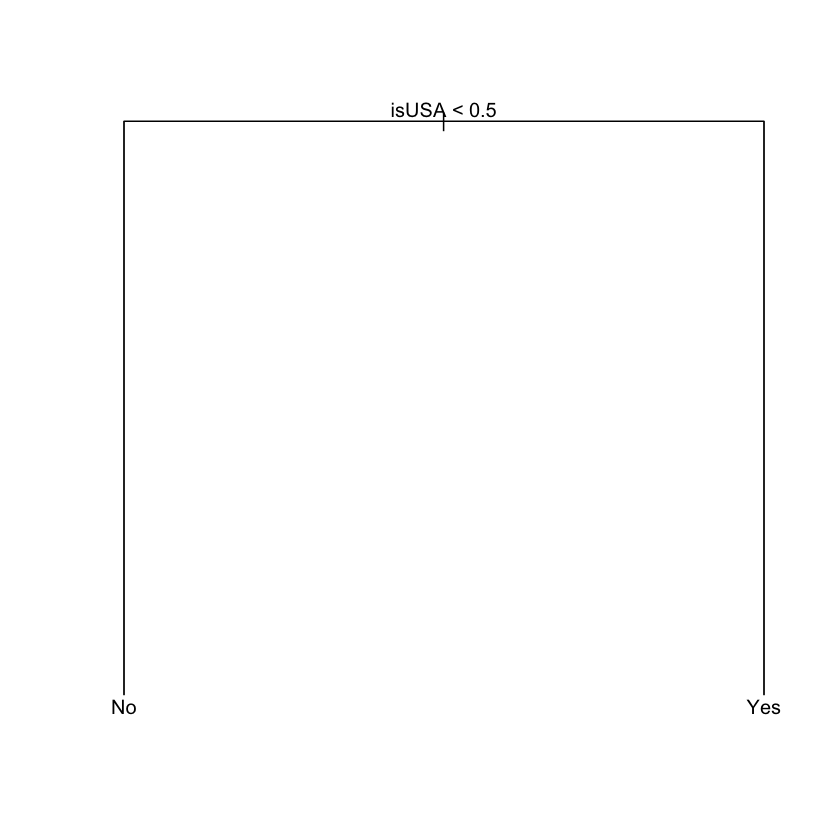

In [36]:
plot(newTree)
text(newTree,pretty = 0)